# Loss Given Default Analysis [TPS August]
![](https://images.unsplash.com/photo-1616514197671-15d99ce7a6f8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1506&q=80)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@constantinevdokimov?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Konstantin Evdokimov</a>
        on 
        <a href='https://unsplash.com/s/photos/loan?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Unsplash.</a> All images are by author unless specified otherwise.
    </strong>
</figcaption>

# 1. Problem definition

In this month's TPS competition, we are tasked to predict the amount of money a bank or a financial institution might lose if a loan goes into default.

Before we start the EDA, let's make sure we are all on the same page on some of the key terms of the problem definition:
1. What is loan default?
   - Default is a failure to repay a debt/loan on time. It can occur when a borrower fails to make timely payments on loans such as mortgage, bank loans, car leases, etc.
2. What is a loss given default (LGD)?
   - LGD is the amount of money a bank or financial institution might lose if a loan goes into default. Calculating and predicting LGD can be complex and involve many factors. 

As you will see in just a bit, the dataset for the competition has over 100 features and the target `loss` is (I think) LGD. For more information on these terms, check out [this](https://www.kaggle.com/c/tabular-playground-series-aug-2021/discussion/256337) discussion thread.

The metric used in this competition is Root Mean Squared Error, a regression metric:
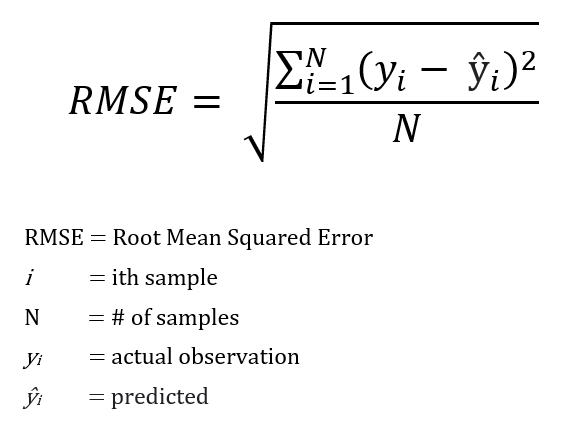

# 2. Setup

In [ ]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import rcParams

warnings.filterwarnings("ignore")
# Global plot configs
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["font.family"] = "monospace"

# Pandas global settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:.5f}".format

# Import data
train_df = pd.read_csv("../input/tabular-playground-series-aug-2021/train.csv", index_col="id")
test_df = pd.read_csv("../input/tabular-playground-series-aug-2021/test.csv", index_col="id")
sub = pd.read_csv("../input/tabular-playground-series-aug-2021/sample_submission.csv")

# Colors
dark_red = "#b20710"
black = "#221f1f"
green = "#009473"

# 3. Overview of the datasets

Both training and test sets have 100 features, excluding the ID column. The target is given as `loss` and has a discrete distribution. 

Some other observations:
- Training and test data contain **250k and 150k** observations, respectively
- There are **no missing values** in both sets
- All features either have `float64` or `int64` type

Here are the first few rows of train and test datasets:

In [ ]:
train_df.head()

In [ ]:
test_df.head()

# 4. Analyzing the distributions of the features

Let's start by looking at the high-level summary of both datasets:

In [ ]:
stat_summary_train = (
    train_df.describe().drop("loss", axis=1).T[["mean", "std", "min", "50%", "max"]]
)

stat_summary_test = test_df.describe().T[["mean", "std", "min", "50%", "max"]]
stat_summary_train.sample(10)

From a random sample of the summary, we can see that features have rather different scales. As a single-metric overview, we will choose and categorize features based on their mean:

In [ ]:
# Bin the mean into categories
bins = [-np.inf, 100, 10000, np.inf]
labels = ["Below 100", "Between 100-10000", "Above 10000"]

stat_summary_train["mean_cats_train"] = pd.cut(
    stat_summary_train["mean"], bins=bins, labels=labels
)

In [ ]:
# Group by mean categories
grouped_train = stat_summary_train.value_counts("mean_cats_train").sort_values(
    ascending=False
)

cmap = [dark_red] * 4

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the bar
bar = grouped_train.plot(kind="bar", ax=ax, color=cmap)

# Display title
fig.text(
    0.5,
    1,
    "Features Grouped by Mean Categories in Train/Test Sets",
    fontfamily="monospace",
    size="20",
    ha="center",
)

# Remove unnecessary elements
ax.yaxis.set_visible(False)
ax.set_xlabel("")
for s in ["top", "left", "right"]:
    ax.spines[s].set_visible(False)

# Annotate above the bars
for patch in ax.patches:
    text = f"{patch.get_height():.0f}"
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height() + 5
    ax.text(x, y, text, ha="center", va="center", fontsize=20)
# Format xticklabels
plt.setp(ax.get_xmajorticklabels(), rotation=0, fontsize="large")
ax.spines["bottom"].set_linewidth(1.5)
fig.text(
    0.6,
    0.5,
    """
The majority of features in 
boths sets have rather low mean.

However, we can observe features
with larger scales. This suggests
we do feature scaling when we get
to preprocessing.
""",
    bbox=dict(boxstyle="round", fc="#009473"),
    fontsize="large",
);

Now, let's look at the distributions of both sets as a whole:

In [ ]:
fig = plt.figure(figsize=(15, 60))
gs = fig.add_gridspec(20, 5)
gs.update(wspace=0.1, hspace=0.4)

# Add 100 subplots for all features
temp = 0
for row in range(0, 20):
    for col in range(0, 5):
        locals()[f"ax_{temp}"] = fig.add_subplot(gs[row, col])
        locals()[f"ax_{temp}"].tick_params(axis="y", left=False)
        locals()[f"ax_{temp}"].get_yaxis().set_visible(False)
        locals()[f"ax_{temp}"].set_axisbelow(True)
        for s in ["top", "right", "left"]:
            locals()[f"ax_{temp}"].spines[s].set_visible(False)
        temp += 1

# General texts
fig.suptitle(
    "Distribution of Features in Train and Test Sets",
    y=0.9,
    fontsize=25,
    fontweight="bold",
    fontfamily="monospace",
)

# Fill subplots with KDEplots of both train and test set features
temp = 0
for feature in test_df.columns.to_list():
    for df, color in zip([train_df, test_df], [dark_red, green]):
        sns.kdeplot(
            df[feature],
            shade=True,
            color=color,
            linewidth=1.5,
            alpha=0.7,
            zorder=3,
            legend=False,
            ax=locals()[f"ax_{temp}"],
        )
    locals()[f"ax_{temp}"].grid(
        which="major", axis="x", zorder=0, color="gray", linestyle=":", dashes=(1, 5)
    )
    locals()[f"ax_{temp}"].set_xlabel(feature)
    temp += 1
plt.show();

Key observations:
- Train and test sets have roughly the same distributions in terms of features. 
- Many features have or almost have **normal distributions**
- Some features are **bimodal**
- Some features are even **trimodal**
- Most features have **skewed distributions**.

We need to think about how to make all these normally distributed if we decide to use non-tree based models.

> Checking the correlation revealed no significant relationships between features (most were between -0.3 and 0.3).

Next, there are 5 features that are discrete. Let's check their cardinality to see any of them may be categorical:

In [ ]:
discrete_cols = [col for col in test_df.columns if test_df[col].dtype == "int64"]

cardinality = train_df[discrete_cols].nunique().sort_values(ascending=False)

colors = [dark_red] * 5
fig, ax = plt.subplots(figsize=(12, 6))
cardinality.plot(kind="bar", color=colors)

# Display title
fig.text(
    0.5,
    1,
    "Cardinality of Discrete Features",
    fontfamily="monospace",
    size="20",
    ha="center",
)

# Remove unnecessary elements
ax.yaxis.set_visible(False)
ax.set_xlabel("")
for s in ["top", "left", "right"]:
    ax.spines[s].set_visible(False)

# Annotate above the bars
for patch in ax.patches:
    text = f"{patch.get_height():.0f}"
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height() + 10000
    ax.text(x, y, text, ha="center", va="center", fontsize=20)

# Format xticklabels
plt.setp(ax.get_xmajorticklabels(), rotation=0, fontsize="large")
ax.spines["bottom"].set_linewidth(1.5)

fig.text(
    0.4,
    0.5,
    """
These discrete features
all have very high cardinality,
meaning it isn't a good idea to
treat them as categorical.
""",
    bbox=dict(boxstyle="round", fc="#009473"),
    fontsize="large",
);

# 5. Analyzing the target

Let's look at the distribution of the target:

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.kdeplot(
    train_df["loss"],
    color=dark_red,
    shade=True,
    ax=ax,
)

ax.set(xlabel="Target - loss")
plt.title(
    "Distribution of the Target",
    ha="center",
    fontfamily="monospace",
    fontsize="large",
    fontweight="bold",
    size=20,
)

fig.text(
    0.4,
    0.5,
    """
The target has a skewed distribution.
""",
    bbox=dict(boxstyle="round", fc="#009473"),
    fontsize="medium",
)

ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)

# 6. XGBoost Baseline

Since the dataset has high dimensionality, we will apply Principal Component Analysis as a base reduction method. We will pass 0.95 to `n_components` so that PCA will find the minimum number of features we need to keep to preserve at least 95% variance of the dataset.

We will perform all of the steps inside Sklearn pipelines ending with a baseline XGBoost regressor:

In [ ]:
%%time

from sklearn.model_selection import KFold, cross_validate, train_test_split
from xgboost import XGBRegressor

# Log transform all features and the target
X, y = train_df.drop("loss", axis=1), train_df[["loss"]]

reg = XGBRegressor(objective="reg:squarederror",
                   tree_method="gpu_hist",)

# Validation set to be used inside early_stopping
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=1121218
)

# Set up `fit_params` for XGBoost
eval_set = [(X_valid, y_valid)]
fit_params = {
    "eval_set": eval_set,
    "eval_metric": "rmse",
    "early_stopping_rounds": 100,
    "verbose": False,
}

_ = reg.fit(X_train, y_train, **fit_params)

In [ ]:
preds = reg.predict(test_df)

In [ ]:
submission = pd.DataFrame({"id": test_df.index, "loss": preds})
submission.to_csv("submission.csv", index=False)